# 인공지능과 가위바위보하기

<br>


## 개요
손글씨 이미지 분류 실습을 통해 학습한 내용을 토대로 가위바위보 게임을 할 수 있는 프로그램을 만들어 보도록 한다. 손글씨 숫자 이미지는 0부터 9까지 총 10개의 클래스로 이루어진 것과는 달리 가위바위보 이미지 분류기는 3가지의 클래스로만 이루어진다. 이미지 분류를 위한 학습에 사용될 데이터셋은 웹캠을 이용하여 직접 생성하여 실제로 어떻게 데이터셋을 만들고 만들어진 데이터를 활용하는지 알아보도록 한다.  
* [이미지 데이터셋 생성 사이트](https://teachablemachine.withgoogle.com/)  

네트워크 설계와 검증이 완료되면 임의의 가위, 바위, 보 사진을 입력받아 그 이미지를 분류하여 컴퓨터가 제시하는 랜덤한 값과 비교하여 승패 여부를 판단하는 프로그램을 완성시킨다.

<br>

## 목차
* 데이터 준비하기
  * 각 클래스의 데이터를 만들어 별도의 디렉터리에 저장
  > dir 명은 rock, scissor, papper로 지정한다.
  * 각 디렉터리에 저장한 이미지 데이터 불러오기
  * 데이터 사이즈 조정
* 딥러닝 네트워크 설계하기
  * Sequential 모델 설계
  > Convolution, pooling, 완전결합 계층을 설계한다.
* 딥러닝 네트워크 학습시키기
  * 매개변수 갱신 방법은 Adam 기법 사용
  * 손실함수는 'sparse_categorical_crossentropy' 사용
* 만들어진 딥러닝 네트워크 검증하기
  * 테스트 데이터셋을 이용하여 만들어진 모델의 성능과 과적합 여부 검증
* 네트워크 정확도 높이기
  * 하이퍼 파라미터 값을 조정하여 더 높은 정확도가 나올 수 있도록 네트워크를 개선
* 가위바위보 게임 로직 구현
  * 이미지 입력받고 분류하기
  * 무작위 값 선정하여 분류된 출력값과 비교하기
  * 승패를 결정하여 승률 계산하기


---
### 데이터 준비하기
학습에 사용할 데이터가 저장되어있는 경로에 접근하여 데이터를 불러오고, 학습에 용이한 형태로 변환하는 과정이다.

In [1]:
from PIL import Image
import glob

# 각 데이터 부모 dir 경로 지정
train_parent_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/train'
validation_parent_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/validation'
kaggle_parent_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/kaggle'

# 학습 데이터 경로 지정
paper_train_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/train/paper'
rock_train_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/train/rock'
scissor_train_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/train/scissor'

# 검증 데이터 경로 지정
paper_validation_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/validation/paper'
rock_validation_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/validation/rock'
scissor_validation_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/validation/scissor'

# 순수 캐글 데이터 경로 지정
paper_kaggle_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/kaggle/paper'
rock_kaggle_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/kaggle/rock'
scissor_kaggle_path = '/Users/leeseonjae/git/Aiffel_Quest/Quest03/kaggle/scissor'

# 각 데이터의 변환 성공 개수를 확인하기 위한 변수 정의
img_num = 0

# 이미지 크기 변환 함수 정의
def resize_images(path):
    global img_num
    images = glob.glob(path+'/*.jpg')

    print(len(images), 'images will be resized.')

    target_size = (28,28)

    # 경로 상에 있는 모든 이미지의 크기를 28X28로 변환한 후, 확장자를 JPEG로 변경
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.LANCZOS)
        new_img.save(img, 'JPEG')

    print(len(images), 'images resized.')

    # 변환 완료된 이미지 개수 갱신
    img_num += len(images)

* 각 종류 별 이미지의 경로를 지정하고 이미지의 크기를 224X224에서 28X28로 변환하고 확장자를 변경하는 함수를 정의한다.

In [2]:
import numpy as np

# 이미지 분류 함수 정의
def load_data(p_path, number_of_data):
    global img_num
    img_size = 28
    color = 3

    # 이미지 데이터와 정답 레이블의 정보 데이터가 들어갈 비어있는 n차원 배열 생성
    imgs = np.zeros(number_of_data*img_size*img_size*color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)

    idx = 0
    # idx 0 영역에 가위 이미지 행렬 복사
    for file in glob.iglob(p_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    # idx 1 영역에 가위 이미지 행렬 복사
    for file in glob.iglob(p_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1  

    # idx 1 영역에 보 이미지 행렬 복사
    for file in glob.iglob(p_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1

    # 이미지 개수 데이터 초기화
    img_num = 0
    return imgs, labels

* 이미지 데이터를 load하여 종류별로 나누고 정답 레이블을 생성하는 함수를 정의한다.

In [3]:
# 학습 데이터 사이즈 변경 및 정답 레이블 분리
resize_images(paper_train_path)
print('Completed resize paper image for train!')

resize_images(rock_train_path)
print('Completed resize rock image for train!')

resize_images(scissor_train_path)
print('Completed resize scissor image for train!')

print('-'*25)
print(f'Number of train images is {img_num}EA.')
print('-'*25)

(x_train, y_train) = load_data(train_parent_path, img_num)



# 검증 데이터 사이즈 변경 및 정답 레이블 분리
resize_images(paper_validation_path)
print('Completed resize paper image for validation!')

resize_images(rock_validation_path)
print('Completed resize rock image for validation!')

resize_images(scissor_validation_path)
print('Completed resize scissor image for validation!')

print('-'*25)
print(f'Number of validation images is {img_num}EA.')
print('-'*25)

(x_val, y_val) = load_data(validation_parent_path, img_num)


# 캐글 데이터 사이즈 변경 및 정답 레이블 분리
resize_images(paper_kaggle_path)
print('Completed resize paper image of kaggle!')

resize_images(rock_kaggle_path)
print('Completed resize rock image of kaggle!')

resize_images(scissor_kaggle_path)
print('Completed resize scissor image of kaggle!')

print('-'*25)
print(f'Number of kaggle images is {img_num}EA.')
print('-'*25)

(x_kag, y_kag) = load_data(kaggle_parent_path, img_num)

2641 images will be resized.
2641 images resized.
Completed resize paper image for train!
2812 images will be resized.
2812 images resized.
Completed resize rock image for train!
2640 images will be resized.
2640 images resized.
Completed resize scissor image for train!
-------------------------
Number of train images is 8093EA.
-------------------------
100 images will be resized.
100 images resized.
Completed resize paper image for validation!
100 images will be resized.
100 images resized.
Completed resize rock image for validation!
100 images will be resized.
100 images resized.
Completed resize scissor image for validation!
-------------------------
Number of validation images is 300EA.
-------------------------
712 images will be resized.
712 images resized.
Completed resize paper image of kaggle!
726 images will be resized.
726 images resized.
Completed resize rock image of kaggle!
750 images will be resized.
750 images resized.
Completed resize scissor image of kaggle!
--------

* 학습 데이터와 검증 데이터, 추후 비교를 위한 캐글에서 다운로드한 데이터를 준비한다.
    * 학습 데이터의 총 개수는 8093개이며, 이미지의 크기는 28X28, 3개의 채널(RGB)로 구성되어 있다.
    * 검증 데이터의 총 개수는 300개이며, 이미지의 크기는 28X28, 3개의 채널(RGB)로 구성되어 있다.
    * 캐글 데이터의 총 개수는 2188개이며, 이미지의 크기는 28X28, 3개의 채널(RGB)로 구성되어 있다.

Label:  0
Label:  0
Label:  0


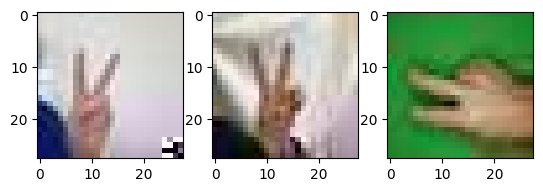

In [4]:
import matplotlib.pyplot as plt

plt.subplot(131)
plt.imshow(x_train[0])
print('Label: ', y_train[0])

plt.subplot(132)
plt.imshow(x_val[0])
print('Label: ', y_val[0])

plt.subplot(133)
plt.imshow(x_kag[0])
print('Label: ', y_kag[0])

plt.show()

* 28X28의 형태로 변환이 되어 선명하게 보이진 않지만, 세 개의 데이터 모두 가위의 형태를 띄고 있고, 그에 맞는 라벨 값이 올바르게 출력된 것을 알 수 있다.

In [5]:
print('학습 데이터 - 최소값:',np.min(x_train), ' 최대값:',np.max(x_train))
print('검증 데이터 - 최소값:',np.min(x_val), ' 최대값:',np.max(x_val))
print('캐글 데이터 - 최소값:',np.min(x_kag), ' 최대값:',np.max(x_kag))

학습 데이터 - 최소값: 0  최대값: 255
검증 데이터 - 최소값: 0  최대값: 255
캐글 데이터 - 최소값: 0  최대값: 255


In [6]:
x_train_norm = x_train / 255.0
x_val_norm = x_val / 255.0
x_kag_norm = x_kag / 255.0

print('학습 데이터 - 최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))
print('검증 데이터 - 최소값:',np.min(x_val_norm), ' 최대값:',np.max(x_val_norm))
print('캐글 데이터 - 최소값:',np.min(x_kag_norm), ' 최대값:',np.max(x_kag_norm))

학습 데이터 - 최소값: 0.0  최대값: 1.0
검증 데이터 - 최소값: 0.0  최대값: 1.0
캐글 데이터 - 최소값: 0.0  최대값: 1.0


* 각 데이터의 최솟값과 최댓값을 확인한 후, 원활한 학습 진행을 위해 0~1사이의 값을 가지도록 정규화를 진행한다.

---
### 딥러닝 네트워크 설계하기
어떤 학습 모델을 사용할 것인지, 신경망은 어떻게 구성할 것인지 고려하며 설계를 진행한다. 해당 단계에서는 keras 모듈의 Sequential 모델을 사용한다.

In [7]:
import tensorflow as tf
# from tensorflow import keras
import numpy as np

#keras의 Sequential 모델로 네트워크 설계
model=tf.keras.models.Sequential()
# 1번 레이어 - 합성곱 계층: 필터 개수 32, 필터 크기 3X3, 활성화 함수 ReLU, 데이터 크기 28X28X3
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
# 2번 레이어 - 풀링 계층: 맥스 풀링, 풀링 크기 2X2, stride 2X2
model.add(tf.keras.layers.MaxPool2D(2,2))
# 3번 레이어 - 합성곱 계층: 필터 개수 32, 필터 크기 3X3, 활성화 함수 ReLU
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
# 4번 레이어 - 풀링 계층: 맥스 풀링, 풀링 크기 2X2, stride 2X2
model.add(tf.keras.layers.MaxPool2D(2,2))
# 5번 레이어 - 데이터 전개 계층: 입력 데이터 전개
model.add(tf.keras.layers.Flatten())
# 6번 레이어 - 완전연결 계층: 뉴런 개수 32, 활성화 함수 ReLU
model.add(tf.keras.layers.Dense(32, activation='relu'))
# 7번 레이어 - 출력 계층: 출력 노드 개수 3, 출력 함수 Softmax 
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

* 두 개의 합성곱 계층과 2개의 풀링 계층을 거쳐 3개의 노드를 출력하는 네트워크 모델을 설계한다.
* 합성곱 계층과 풀링 계층을 거친 후 출력 계층에 도달하기 전까지 데이터 전개와 완전연결 계층을 거치게 된다.

---
### 딥러닝 네트워크 학습시키기
학습을 진행할 때 가중치 업데이트 방법, 손실함수, 평가지표 등 고려해야할 사항과 그 종류를 파악해야 한다. 학습 과정의 정확도와 학습 완료 후의 정확도를 비교하며 학습이 진행하는 과정에서의 정확도의 변화를 주시한다.

In [8]:
# 가중치 업데이트 기법 adam, 손실함수 sparse_categorical_crossentropy, 평가지표 정확도
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
253/253 [==============================] - 2s 6ms/step - loss: 0.7461 - accuracy: 0.6635
Epoch 2/10
253/253 [==============================] - 2s 6ms/step - loss: 0.2833 - accuracy: 0.9035
Epoch 3/10
253/253 [==============================] - 1s 5ms/step - loss: 0.1786 - accuracy: 0.9397
Epoch 4/10
253/253 [==============================] - 1s 5ms/step - loss: 0.1117 - accuracy: 0.9645
Epoch 5/10
253/253 [==============================] - 1s 6ms/step - loss: 0.0770 - accuracy: 0.9762
Epoch 6/10
253/253 [==============================] - 1s 6ms/step - loss: 0.0574 - accuracy: 0.9821
Epoch 7/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0418 - accuracy: 0.9888
Epoch 8/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0273 - accuracy: 0.9921
Epoch 9/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0236 - accuracy: 0.9939
Epoch 10/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0218 - accuracy: 0.9942

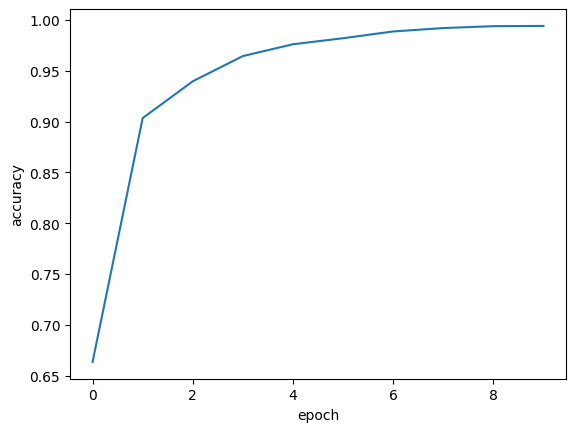

In [9]:
# 에폭 증가에 따른 정확도 변화를 그래프로 그리기
history = model.history

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

* 에폭을 거칠수록 정확도가 점점 증가하는 것을 확인할 수 있다.
> 학습 진행에 따른 정확도는 증가하지만 검증 시 출력되는 정확도도 위와 같이 약 99.4%를 보일지는 미지수이다.  
> 검증 데이터를 통해 두 정확도 간의 차이를 확인해 봐야한다.

---
### 만들어진 딥러닝 네트워크 검증하기
지정된 데이터만으로 학습을 진행하다보면 오버피팅의 염려가 있다. 새로운 검증 데이터를 통해 오버피팅 여부를 확인하여 모델의 성능을 파악한다.

In [10]:
# 검증 데이터를 통해 검증 진행 - verbose = 2로 각 에폭마다의 진행 상황을 확인
val_loss, val_accuracy = model.evaluate(x_val_norm,y_val, verbose=2)
print(f"validation_loss: {val_loss}")
print(f"validation_accuracy: {val_accuracy}")

10/10 - 0s - loss: 4.2570 - accuracy: 0.6200 - 96ms/epoch - 10ms/step
validation_loss: 4.257004737854004
validation_accuracy: 0.6200000047683716


* 검증 데이터로 검증을 진행한 결과 약 62%의 정확도가 출력됐다.
> 학습 결과 정확도는 약 99.4%였지만, 검증 결과 정확도는 약 62%로 37% 이상의 차이를 보이고 있다.  
> 이 경우, 학습 데이터에 맟춤으로 과도하게 학습이 진행이된 오버피팅을 의심할 수 있다.

Epoch 1/100
32/32 [==============================] - 1s 22ms/step - loss: 1.3451 - acc: 0.3413 - val_loss: 1.1179 - val_acc: 0.3333
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 1.2138 - acc: 0.3635 - val_loss: 1.1053 - val_acc: 0.4367
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 1.1230 - acc: 0.4024 - val_loss: 1.1032 - val_acc: 0.3600
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 1.0479 - acc: 0.4625 - val_loss: 1.0986 - val_acc: 0.3833
Epoch 5/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9872 - acc: 0.5251 - val_loss: 1.0862 - val_acc: 0.5133
Epoch 6/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9330 - acc: 0.5562 - val_loss: 1.0580 - val_acc: 0.5633
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8637 - acc: 0.6109 - val_loss: 1.0080 - val_acc: 0.6200
Epoch 8/100
32/32 [==============================] - 1s 20ms/step - loss: 0.

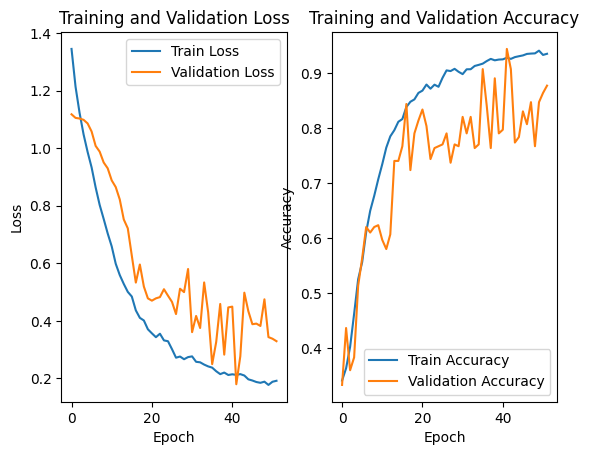

In [49]:
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras import regularizers


# Sequential 모델 생성
model = tf.keras.models.Sequential()

# 필터 개수 32 -> 8로 수정, 필터 크기 3X3 -> 5X5로 수정
model.add(tf.keras.layers.Conv2D(8, (5,5), activation='relu', input_shape=(28,28,3)))
model.add(tf.keras.layers.MaxPool2D(2,2))

# 필터 개수 32 -> 8로 수정, 필터 크기 3X3 -> 5X5로 수정
model.add(tf.keras.layers.Conv2D(8, (5,5), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))

model.add(tf.keras.layers.Flatten())
# 드롭아웃 추가 - 오버피팅 방지를 위해 전체 뉴런의 50%만 사용하여 학습 진행
model.add(tf.keras.layers.Dropout(0.5))

# 뉴런 개수 32개 -> 8개로 수정, L2 규제 0.001 추가
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# 학습률 0.001로 지정
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

# EarlyStopping 콜백 정의 -  검증 데이터의 손실값이 10번 이상 연속해서 개선되지 않을 경우 훈련을 조기에 종료
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 에폭 수 10회 -> 100회로 증량, 미니 배치 256 추가, callback 추가
history = model.fit(x_train_norm, y_train, batch_size=256,
                    epochs=100, 
                    validation_data=(x_val_norm, y_val),
                    callbacks=[early_stopping])

# 검증 데이터에 대한 손실과 정확도 출력
val_loss, val_accuracy = model.evaluate(x_val_norm, y_val, verbose=2)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# 손실 및 정확도 그래프 그리기
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 오버피팅 문제를 해결하기 위해 일부 하이퍼 파라미터 값을 조정하고 일부 가중치 감소 기법을 추가한다.
    * 합성곱 계층의 필터 수와 필터 크기 변경
    * 드롭아웃 기법을 추가하여 전체 뉴런의 50%만 학습에 참여
    * 완전연결 계층의 뉴런 수를 변경하고 L2 규제 추가
    * Adam 기법의 학습률 지정
    * 콜백 기법 추가
    * 에폭 수 증량과 미니 배치 기법 추가
 
### 최종 결과
* 상기 요약된 내용을 적용하여 초기 61%의 정확도가 87.6%로 약 26% 이상 향상된 성능을 확인할 수 있다. 

Epoch 1/100
9/9 [==============================] - 0s 28ms/step - loss: 1.2882 - acc: 0.3414 - val_loss: 1.2335 - val_acc: 0.3333
Epoch 2/100
9/9 [==============================] - 0s 21ms/step - loss: 1.1802 - acc: 0.3848 - val_loss: 1.1661 - val_acc: 0.3333
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 1.0582 - acc: 0.4538 - val_loss: 1.1375 - val_acc: 0.3333
Epoch 4/100
9/9 [==============================] - 0s 21ms/step - loss: 0.9415 - acc: 0.5841 - val_loss: 1.1255 - val_acc: 0.3733
Epoch 5/100
9/9 [==============================] - 0s 21ms/step - loss: 0.8523 - acc: 0.6586 - val_loss: 1.1366 - val_acc: 0.3867
Epoch 6/100
9/9 [==============================] - 0s 21ms/step - loss: 0.7927 - acc: 0.6952 - val_loss: 1.1415 - val_acc: 0.3800
Epoch 7/100
9/9 [==============================] - 0s 21ms/step - loss: 0.7210 - acc: 0.7468 - val_loss: 1.1624 - val_acc: 0.2967
Epoch 8/100
9/9 [==============================] - 0s 21ms/step - loss: 0.6636 - acc: 0.78

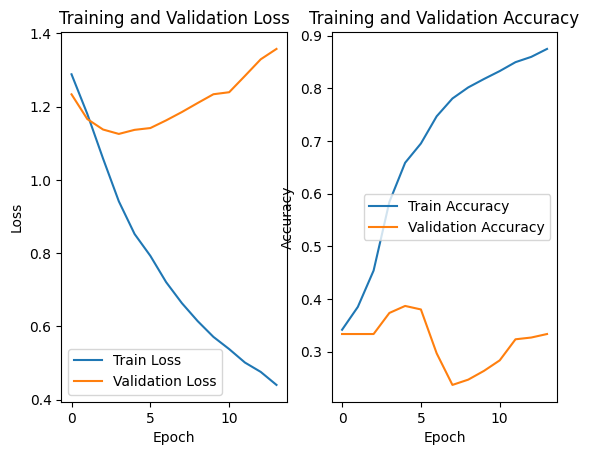

In [50]:
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras import regularizers


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(8, (5,5), activation='relu', input_shape=(28,28,3)))
model.add(tf.keras.layers.MaxPool2D(2,2))

model.add(tf.keras.layers.Conv2D(8, (5,5), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 학습 데이터가 아닌 캐글 데이터로 학습을 진행
history = model.fit(x_kag_norm, y_kag, batch_size=256,
                    epochs=100, 
                    validation_data=(x_val_norm, y_val),
                    callbacks=[early_stopping])

val_loss, val_accuracy = model.evaluate(x_val_norm, y_val, verbose=2)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 그루들이 직접 만든 데이터가 아닌 잘 만들어진 캐글 데이터만으로 학습을 진행해본다.
> 잘 만들어진 데이터라고는 하나 데이터셋의 크기가 너무 작아 오버피팅이 일어났을 확률이 높아보인다.

---
## 요약
가위, 바위, 보 이미지 데이터를 학습 시킨 후, 이미지 분류기를 만들어봤다. 처음 검증 정확도가 61%가 나왔고, 하이퍼 파라미터 조정을 통한 필터 개수, 필터 크기 변환 등의 작업으로 검증 정확도를 약 87.6%까지 상향시켰다. 그래프를 확인했을 때 에폭 진행에 따른 검증 정확도가 들쑥날쑥한 모양을 하고 있어 네트워크 자체 성능에 대해서는 좋다고 판단하기 어려워 보이지만, 전체 그래프를 보면 비교적 일관적인 상승세를 보이고 있어 이는 학습 데이터 자체의 노이즈도 영향을 미치지 않을까 판단된다. 캐글의 데이터로 학습을 진행하여 비교를 해보려 했지만, 캐글 자체의 데이터도 대량의 데이터는 아니기에 오버피팅 이슈가 발생한 것처럼 보여 정확한 검증 방법을 좀 더 연구해봐야할 것 같다.

<br>

<br>

## 회고

### KEEP
* 정확도를 올리려는 과정에서 조정하는 항목에 대해 이해했다.
* 데이터를 생성하고 학습까지 하나의 플로우를 이해하며 학습했다.
* 각각의 하이퍼 파라미터 조정에 따른 정확도 변화를 그래프를 통해 이해했다.

### PROBLEM
* 각각의 하이퍼 파라미터가 상호간에 미치는 영향은 아직 파악하지 못했다.
* 값의 변화만 파악하고 값이 나오는 이유를 제대로 이해하지 못했다.

### TRY
* 각각의 하이퍼 파라미터 값이 결과와 다른 요소들에 미치는 영향에 대한 문서가 있는지 찾아본다.
* 보다 상세한 테스트 케이스를 설계하여 체계적인 연구를 진행한다.